In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import numpy as np
import yfinance as yf
from time import time

In [2]:
import warnings
warnings.filterwarnings('ignore')
import random
#random.seed(42)

### Function Definitions

In [3]:
def train_val_splits(data=[0]*7640, train_size=2000, val_size=500, step=250):
  n_data = len(data)
  if (train_size + val_size > n_data): return [],[]
  n_sets = (n_data - (train_size + val_size)) // step + 1
  train_sets = []
  val_sets = []
  for i in range(n_sets) :
    start_index = i * step
    train_sets.append(data[start_index : start_index+train_size])
    val_sets.append(data[start_index+train_size : start_index+train_size+val_size])
  train_sets.append(data[-(train_size+val_size):-val_size])
  val_sets.append(data[-val_size:])
  return train_sets, val_sets

In [4]:
def thresholds_model_trial(df, colname):
  min_val = min(df[colname])
  max_val = max(df[colname])
  max_total = 0
  l_thr = 0.01
  u_thr = 0.02

  lower = np.arange(min_val, min(max_val, 0.16), 0.01)
  for l in lower:
    diff = np.arange(0.05, max_val-l, 0.05)
    for d in diff:
      pred_bull = df[(df[colname]<=l) & (df['State']==1)]
      pred_bear = df[(df[colname]>=l+d) & (df['State']==-1)]
      total_bull = df[df['State']== 1]
      total_bear = df[df['State']== -1]
      lower_points = df[df[colname]<=l]
      upper_points = df[df[colname]>=l+d]

      total = len(pred_bull)/len(lower_points) + len(pred_bear)/len(upper_points) + len(pred_bull)/len(total_bull) + len(pred_bear)/len(total_bear)

      if (total > max_total):
        max_total = total
        l_thr = l
        u_thr = l+d
  
  return l_thr, u_thr

def thresholds_model(df, colname):
  min_val = min(df[colname])
  max_val = max(df[colname])
  max_total = 0
  l_thr = 0.01
  u_thr = 0.02

  lower = np.arange(min_val+0.02, min(max_val, 0.16), 0.01)
  for l in lower:
    diff = np.arange(0.05, max_val-l, 0.05)
    for d in diff:
      true_bull = df[(df[colname]<=l) & (df['State']==1)]
      true_bear = df[(df[colname]>=l+d) & (df['State']==-1)]
      lower_points = df[df[colname]<=l]
      upper_points = df[df[colname]>=l+d]
      
      total = len(true_bull)/len(df[df[colname]<=l]) + len(true_bear)/len(df[df[colname]>=l+d])
      if (total > max_total):
        max_total = total
        l_thr = l
        u_thr = l+d
  
  return l_thr, u_thr

def thresholds_states(df, l_thr, u_thr, colname, statename):
  df[statename] = 0
  for i in range(len(df)):
    if (df[colname].iloc[i] >= u_thr):
      df[statename].iloc[i] = -1
    elif(df[colname].iloc[i] <= l_thr):
      df[statename].iloc[i] = 1
    else:
      df[statename].iloc[i] = 0

  return df

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

def random_forest(split_data, prnt = True):

  train_x = split_data[0]
  train_y = split_data[1]
  test_x = split_data[2]
  test_y = split_data[3]

  estimators = np.arange(70, 130, 10)
  acc = []
  train_preds = []
  models = []

  for estimator in estimators:
    model = RandomForestClassifier(n_estimators=estimator, max_depth=8)
    model = model.fit(train_x, train_y)
    models.append(model)

    train_pred = model.predict(train_x)
    train_correct = 0
    for i in range(len(train_pred)):
      if train_pred[i] == train_y[i]:
        train_correct += 1

    model_acc = train_correct/len(train_pred)
    acc.append(model_acc)
    
    train_preds.append(train_pred)

  best_model = models[np.argmax(acc)]
  test_pred = best_model.predict(test_x)
  correct = 0
  for i in range(len(test_pred)):
    if test_pred[i] == test_y[i]:
      correct += 1

  test_acc = correct/len(test_pred)

  if prnt:
    print("Best training accuracy = ", acc[np.argmax(acc)])
    print("Nodes = ", estimators[np.argmax(acc)])
    print("Test Accuracy = ", test_acc)
    print("True Bull states = ", sum(test_y == 1))
    print("True Bear states = ", sum(test_y == -1))
    print("True Neutral states = ", sum(test_y == 0))
    print("Predicted Bull states = ", sum(test_pred == 1))
    print("Predicted Bear states = ", sum(test_pred == -1))
    print("Predicted Neutral states = ", sum(test_pred == 0))
    print("\n")

  return train_pred[np.argmax(acc)], test_pred

In [6]:
def get_final_state(ts, indname):
    ts['State'] = 0
    
    curr_ms = ts['HMM'][0]
    curr_hmm = ts['HMM'][0]
    curr_ind = ts[indname][0]
    state_dict = 'hmm'

    dict_changes = 0
    
    for i in range(1, len(ts)):
        hmm_st_ch = 0
        ind_st_ch = 0
        
        hmm_state = ts['HMM'].iloc[i]
        if i < 5:
            ind_state = ts[indname].iloc[i]
        else:
            ind_arr = list(np.asarray(ts[indname].iloc[i-4:i]))
            ind_state = max(ind_arr, key=ind_arr.count)
        
        
        if i > 1:
            if hmm_state != curr_hmm:
                hmm_st_ch = 1

            if ind_state != curr_ind:
                ind_st_ch = 1
            
        if state_dict == 'hmm' and ind_st_ch == 1:
            if ind_state == hmm_state:
                curr_ms = hmm_state
                ts['State'].iloc[i] = curr_ms
            else:
                curr_ms = ind_state
                ts['State'].iloc[i] = curr_ms
                state_dict = 'ind'
                dict_changes += 1
        elif state_dict == 'hmm' and ind_st_ch == 0:
            curr_ms = hmm_state
            ts['State'].iloc[i] = curr_ms
        elif state_dict == 'ind' and hmm_st_ch == 1:
            if hmm_state == ind_state:
                curr_ms = ind_state
                ts['State'].iloc[i] = curr_ms
            else:
                curr_ms = hmm_state
                ts['State'].iloc[i] = curr_ms
                state_dict = 'hmm'
                dict_changes += 1
        elif state_dict == 'ind' and hmm_st_ch == 0:
            curr_ms = ind_state
            ts['State'].iloc[i] = curr_ms
            
        curr_hmm = hmm_state
        curr_ind = ind_state

    return ts

In [7]:
def buy_and_hold2(ts, start_date, end_date):
    capital = 1
    ts_start = ts.index[0]
    daily_returns = []
    cumulative = [capital]
    offset = len(ts[ts_start:start_date]) - 1
    length = len(ts[start_date:end_date])
    
    for i in range(0, length-1):
        ret = ts['Adj Close'][offset+i+1]/ts['Adj Close'][offset+i] - 1
        capital = capital*(1+ret)
        daily_returns.append(ret)
        cumulative.append(capital)
    
    cum_return = capital - 1
    n = length-1
    ann_return = np.power((1+cum_return), (252/n)) - 1
    return cum_return, ann_return, daily_returns, cumulative
        

def buy_and_hold(ts, start_date, end_date):
    cum_return = ts.loc[end_date]['Adj Close']/ts.loc[start_date]['Adj Close'] - 1  
    n = len(ts[start_date:end_date]) - 1
    ann_return = np.power((1+cum_return), (252/n)) - 1
    return cum_return, ann_return

def basic_strat(ts, start_date, end_date, three_m_t_bill = 0.0028):
    turnover = 0
    trade = 0
    curr_trade = 1
    capital = 1
    t_bill_rate = get_daily_rate(three_m_t_bill)
    ts_start = ts.index[0]
    
    daily_returns = []
    cumulative = [capital]

    offset = len(ts[ts_start:start_date]) - 1
    length = len(ts[start_date:end_date])

    for i in range(0, length-1):
        if ts['State'][offset+i] == 1:
            ret = ts['Adj Close'][offset+i+1]/ts['Adj Close'][offset+i] - 1
            capital = capital*(1+ret)
            daily_returns.append(ret)
            cumulative.append(capital)
            trade = 1
        elif ts['State'][offset+i] == 0:
            ret = t_bill_rate
            capital = capital*(1+ret)
            daily_returns.append(ret)
            cumulative.append(capital)
            trade = 0
        elif ts['State'][offset+i] == -1:
            ret = ts['Adj Close'][offset+i]/ts['Adj Close'][offset+i+1] - 1
            capital = capital*(1+ret)
            daily_returns.append(ret)
            cumulative.append(capital)
            trade = -1
        
        if trade != curr_trade:
            turnover += 1
            curr_trade = trade
    
    cum_return = capital - 1
    n = len(ts[start_date:end_date]) - 1
    ann_return = np.power((1+cum_return), (252/n)) - 1

    return cum_return, ann_return, turnover, daily_returns, cumulative


def buy_n_hold_payoff(ts):
    cum_return = ts.iloc[-1]['Adj Close']/ts.iloc[0]['Adj Close'] - 1  
    n = len(ts) - 1
    ann_return = np.power((1+cum_return), (252/n)) - 1
    return cum_return, ann_return

def get_daily_rate(three_month):
    daily = np.power((1+three_month), 1/66) - 1
    return daily

def strat_payoff(ts, three_m_t_bill = 0.0028):
    turnover = 0
    trade = 0
    curr_trade = 1
    capital = 1
    t_bill_rate = get_daily_rate(three_m_t_bill)
    ts = ts.reset_index()
    ts_start = ts.index[0]
    ts_end = ts.index[-1]
    length = len(ts)

    for i in range(ts_start, ts_end-1):
        if ts['State'][i] == 1:
            capital = capital*(ts['Adj Close'][i+1]/ts['Adj Close'][i])
            trade = 1
        elif ts['State'][i] == 0:
            capital = capital*(1+t_bill_rate)
            trade = 0
        elif ts['State'][i] == -1:
            capital = capital*(ts['Adj Close'][i]/ts['Adj Close'][i+1])
            trade = -1
        
        if trade != curr_trade:
            turnover += 1
            curr_trade = trade
    
    cum_return = capital - 1
    n = len(ts) - 1
    ann_return = np.power((1+cum_return), (252/n)) - 1
    

    return cum_return, ann_return, turnover

In [8]:
def pltcolorstate(state):
    cols = []
    for s in state:
        if s==0:
            cols.append('orange')
        elif s==1:
            cols.append('green')
        else:
            cols.append('red')
    return cols

In [9]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

def plot_graph2(df, colname='State', string="Predictions"):
    cols = pltcolorstate(df[colname])
    
    formatter = DateFormatter("%Y")
    locator = mdates.YearLocator()
    
    fig = plt.figure(figsize=(15, 6))
    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    plt.scatter(df.index, df['Adj Close'], c=cols, s=5)
    plt.xlabel("Date", fontsize = 25)
    plt.ylabel("Russell 3000 Index", fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    plt.title(string, fontsize=25)
    plt.show()
    

def plot_graph(df, colname = 'State'):
    cols = pltcolorstate(df[colname])
    plt.figure(figsize = (15, 6))
    plt.scatter(df.index, df['Adj Close'], c=cols, s=5)
    plt.xlabel("Date", fontsize = 25)
    plt.ylabel("Russell 3000 Index", fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.xticks(rotation=90)
    plt.yticks(fontsize = 25)
    plt.title("predictions")
    plt.show()

In [10]:
def fix_data(df, drop_unnamed=False, set_index=False, fix_states=False):

  if drop_unnamed:
    df = df.drop(columns='Unnamed: 0',axis=1)

  if set_index:
    df = df.set_index(df['Date'])
    df = df.drop(columns='Date',axis=1)

  if fix_states:
    df['State'] = df['State'].replace(1, -1)
    df['State'] = df['State'].replace(0, 1)
    df['State'] = df['State'].replace(2, 0)

  return df

In [11]:
def get_results(train_set, val_set):  
  train_pnl = train_set[['Adj Close', 'State']]
  val_pnl = val_set[['Adj Close', 'State']]

  tr_bnh_cum, tr_bnh_ann = buy_n_hold_payoff(train_pnl)
  tr_strat_cum, tr_strat_ann, tr_strat_turnover = strat_payoff(train_pnl)

  val_bnh_cum, val_bnh_ann = buy_n_hold_payoff(val_pnl)
  val_strat_cum, val_strat_ann, val_strat_turnover = strat_payoff(val_pnl)

  val_outperform = 0

  print("Train: ")
  print("Buy and Hold Cum Return = ", tr_bnh_cum)
  print("Strategy Cum Return = ", tr_strat_cum)
  if tr_strat_cum > tr_bnh_cum:
    print("Strategy outperforms in training")
  else:
    print("Strategy underperforms in training")
  print("\n")

  print("Validation: ")
  print("Buy and Hold Cum Return = ", val_bnh_cum)
  print("Strategy Cum Return = ", val_strat_cum)
  if val_strat_cum > val_bnh_cum:
    print("Strategy outperforms in validation")
    val_outperform = 1
  else:
    print("Strategy underperforms in validation")
  print("\n")

  excess_ret = val_strat_cum - val_bnh_cum

  return val_outperform, excess_ret

In [12]:
def get_hmm_pnl(hmm_df):
  hmm_cum, hmm_ann, hmm_turnover = strat_payoff(hmm_df)
  return hmm_cum

In [13]:
def get_hmm_all_mapping(prices, states):

  prices_df = pd.DataFrame(prices, columns = ['Adj Close'], index = prices.index)


  #Mapping 1
  new_state1 = np.zeros(len(states))
  for i in range(len(new_state1)):
    if states[i] == 0:
      new_state1[i] = -1
    if states[i] == 1:
      new_state1[i] = 0
    if states[i] == 2:
      new_state1[i] = 1

  new_state1_df = pd.DataFrame(new_state1, columns = ['State'], index = prices[1:].index)
  temp1 = prices_df.join(new_state1_df)
  payoff1 = get_hmm_pnl(temp1)

  max = payoff1
  final_state = new_state1
  state_mapping = [-1, 0, 1]

  #Mapping 2
  new_state2 = np.zeros(len(states))
  for i in range(len(new_state2)):
    if states[i] == 0:
      new_state2[i] = -1
    if states[i] == 1:
      new_state2[i] = 1
    if states[i] == 2:
      new_state2[i] = 0
    
  new_state2_df = pd.DataFrame(new_state2, columns = ['State'], index = prices[1:].index)
  temp2 = prices_df.join(new_state2_df)
  payoff2 = get_hmm_pnl(temp2)

  if payoff2 > max:
    max = payoff2
    final_state = new_state2
    state_mapping = [-1, 1, 0]

  #Mapping 3
  new_state3 = np.zeros(len(states))
  for i in range(len(new_state3)):
    if states[i] == 0:
      new_state3[i] = 0
    if states[i] == 1:
      new_state3[i] = -1
    if states[i] == 2:
      new_state3[i] = 1
  
  new_state3_df = pd.DataFrame(new_state3, columns = ['State'], index = prices[1:].index)
  temp3 = prices_df.join(new_state3_df)
  payoff3 = get_hmm_pnl(temp3)

  if payoff3 > max:
    max = payoff3
    final_state = new_state3
    state_mapping = [0, -1, 1]

  #Mapping 4
  new_state4 = np.zeros(len(states))
  for i in range(len(new_state4)):
    if states[i] == 0:
      new_state4[i] = 0
    if states[i] == 1:
      new_state4[i] = 1
    if states[i] == 2:
      new_state4[i] = -1

  new_state4_df = pd.DataFrame(new_state4, columns = ['State'], index = prices[1:].index)
  temp4 = prices_df.join(new_state4_df)
  payoff4 = get_hmm_pnl(temp4)

  if payoff4 > max:
    max = payoff4
    final_state = new_state4
    state_mapping = [0, 1, -1]

  #Mapping 5
  new_state5 = np.zeros(len(states))
  for i in range(len(new_state5)):
    if states[i] == 0:
      new_state5[i] = 1
    if states[i] == 1:
      new_state5[i] = -1
    if states[i] == 2:
      new_state5[i] = 0

  new_state5_df = pd.DataFrame(new_state5, columns = ['State'], index = prices[1:].index)
  temp5 = prices_df.join(new_state5_df)
  payoff5 = get_hmm_pnl(temp5)

  if payoff5 > max:
    max = payoff5
    final_state = new_state5
    state_mapping = [1, -1, 0]

  #Mapping 6
  new_state6 = np.zeros(len(states))
  for i in range(len(new_state6)):
    if states[i] == 0:
      new_state6[i] = 1
    if states[i] == 1:
      new_state6[i] = 0
    if states[i] == 2:
      new_state6[i] = -1

  new_state6_df = pd.DataFrame(new_state6, columns = ['State'], index = prices[1:].index)
  temp6 = prices_df.join(new_state6_df)
  payoff6 = get_hmm_pnl(temp6)

  if payoff6 > max:
    max = payoff6
    final_state = new_state6
    state_mapping = [1, 0, -1]
  
  return final_state, state_mapping

In [14]:
def run_hmm(train, test):
  train_data = train.values
  train_returns = (train_data[1:]-train_data[:-1])/train_data[:-1]
  

  test_data = test.values
  test_returns = (test_data[1:]-test_data[:-1])/test_data[:-1]
  

  model = hmm.GaussianHMM(n_components = 3, covariance_type="diag", n_iter = 75);
  train_obs = train_returns.reshape(-1, 1)
  test_obs = test_returns.reshape(-1, 1)

  model.fit(train_obs)
  train_preds = model.predict(train_obs)
  test_preds = model.predict(test_obs)

  train_preds_final, state_mapping = get_hmm_all_mapping(train, train_preds)

  test_preds_final = np.zeros(len(test_preds))
  for i in range(len(test_preds_final)):
    if test_preds[i] == 0:
      test_preds_final[i] = state_mapping[0]
    if test_preds[i] == 1:
      test_preds_final[i] = state_mapping[1]
    if test_preds[i] == 2:
      test_preds_final[i] = state_mapping[2]

  train_prices = pd.DataFrame(train, columns = ['Adj Close'], index = train.index)
  train_preds_df = pd.DataFrame(train_preds_final, columns = ['State'], index = train[1:].index)
  train_df = train_prices.join(train_preds_df)

  test_prices = pd.DataFrame(test, columns = ['Adj Close'], index = test.index)
  test_preds_df = pd.DataFrame(test_preds_final, columns = ['State'], index = test[1:].index)
  test_df = test_prices.join(test_preds_df)

  #plot_graph2(train_df)
  #plot_graph2(test_df)

  return train_preds_df, test_preds_df
  #return train_obs, test_obs

In [15]:
def get_sharpe_ratio(daily_returns):
    monthly_returns = []
    monthly_cum_ret = []
    for i in range(20, len(daily_returns), 20):
        monthly_returns.append(daily_returns[i-20:i])
    
    for j in range(len(monthly_returns)):
        capital = 1
        for k in range(len(monthly_returns[j])):
            capital = capital*(1+monthly_returns[j][k])
        month_ret = capital - 1
        #print(month_ret)
        monthly_cum_ret.append(month_ret)
        
    mean_monthly = np.mean(monthly_cum_ret)
    std_monthly = np.std(monthly_cum_ret)
    
    sr = mean_monthly/std_monthly
    return sr

In [16]:
def get_payoffs(ts, start_date, end_date):
    bnh_cum, bnh_ann, bnh_returns, bnh_cumulative = buy_and_hold2(ts, start_date, end_date)
    trade_cum, trade_ann, turnover, trade_returns, trade_cumulative = basic_strat(ts, start_date, end_date)
    
    bnh_sr = get_sharpe_ratio(bnh_returns)
    trade_sr = get_sharpe_ratio(trade_returns)
    
    print("Buy and Hold:")
    print("Cumulative Return = ", round(bnh_cum*100, 3), 
          "% | Annualized Return = ", round(bnh_ann*100, 3), "%")
    print("Sharpe Ratio of monthly returns = ", round(bnh_sr, 3))
    print("\n")
    print("Trading Strategy:")
    print("Cumulative Return = ", round(trade_cum*100, 3), 
          "% | Annualized Return = ", round(trade_ann*100, 3), "%")
    print("Number of trades = ", turnover)
    print("Sharpe Ratio of monthly returns = ", round(trade_sr, 3))
    print("\n")
    
    formatter = DateFormatter("%Y")
    locator = mdates.YearLocator()
    
    fig = plt.figure(figsize=(15, 6))
    ax = plt.gca()
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
    plt.plot(ts[start_date:end_date].index, bnh_cumulative, c='orange', label = 'Buy and Hold')
    plt.plot(ts[start_date:end_date].index, trade_cumulative, c='green', label = 'Trading Strategy')
    plt.xlabel("Date", fontsize = 25)
    plt.ylabel("Cumulative Returns", fontsize = 25)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    plt.legend(prop={'size':25})
    plt.show()

def run(ts, total=True, train=True, test=True):
    total_start = ts.index[0]
    total_end = '12/31/21'
    train_start = ts.index[0]
    train_end = '12/27/17'
    test_start = '1/3/18'
    test_end = '12/31/21'
    
    if total:
        print('\033[1m', 'Total Dataset: ', total_start, ' to ', total_end, '\033[0m')
        get_payoffs(ts, total_start, total_end)
    
    if train:
        print('\033[1m', 'Train Data: ', train_start, ' to ', train_end, '\033[0m')
        get_payoffs(ts, train_start, train_end)
    
    if test:
        print('\033[1m', 'Test Data: ', test_start, ' to ', test_end, '\033[0m')
        get_payoffs(ts, test_start, test_end)

### Load Final Data

In [17]:
data = pd.read_csv("https://raw.githubusercontent.com/sukritik/DataRussell3000/main/Final_Data.csv")
data = fix_data(data, drop_unnamed=False, set_index=True, fix_states=False)
data = data.drop(columns=['T-1 3M Imp Vol', 'T-1 Hist Vol',
       'T-1 Hist Vol SMAVG (15)', 'T-1 Imp - Hist Vol', 'T-1 Imp - Hist Vol %',
       'T-1 Imp - prev Hist', 'T-1 Imp - prev Hist %',
       'T-1 Imp Dev from SMA Hist'])

In [18]:
data['Biweekly Russ vol'] = data['T-1 Daily Returns'].rolling(10).std()
data_train = data.iloc[:7640, ]
data_test = data.iloc[7640:, ]

hmm_train = data_train['Adj Close']
hmm_test = data_test['Adj Close']


data_train = data_train.dropna()
data_test = data_test.dropna()

In [19]:
data.index = pd.to_datetime(data.index)

In [36]:
train_sets, val_sets = train_val_splits(data_train, train_size=1500, val_size=750 )

for i in range(len(train_sets)):
    train_sets[i].index = pd.to_datetime(train_sets[i].index)
    val_sets[i].index = pd.to_datetime(val_sets[i].index)

### Train Models and Get Validation Predictions

**HMM**

In [37]:
for i in range(len(train_sets)):
  train_sets[i]['HMM'], val_sets[i]['HMM'] = run_hmm(train_sets[i]['Adj Close'], val_sets[i]['Adj Close'])

**Model 1**

In [38]:
for i in range(len(train_sets)):
  model1_features = ['T-1 Daily Returns', 'T-1 Fluc', 'T-1 HY Spread', 'T-1 Open-Close', 'T-1 VIX Dev from SMA15']
  model1_target = ['State']

  train_x = train_sets[i][model1_features].to_numpy()
  train_y = train_sets[i][model1_target].to_numpy().flatten()
  test_x = val_sets[i][model1_features].to_numpy()
  test_y = val_sets[i][model1_target].to_numpy().flatten()

  split_data = [train_x, train_y, test_x, test_y]
  model1_train_pred, model1_test_pred = random_forest(split_data, prnt=False)

  train_sets[i]['Model1'] = model1_train_pred
  val_sets[i]['Model1'] = model1_test_pred

**Model 2**

In [39]:
for i in range(len(train_sets)):
  model2_features = ['Biweekly vol of vol', 'T-1 Fluc']
  model2_target = ['State']

  train_x = train_sets[i][model2_features].to_numpy()
  train_y = train_sets[i][model2_target].to_numpy().flatten()
  test_x = val_sets[i][model2_features].to_numpy()
  test_y = val_sets[i][model2_target].to_numpy().flatten()

  split_data = [train_x, train_y, test_x, test_y]
  model2_train_pred, model2_test_pred = random_forest(split_data, prnt=False)

  train_sets[i]['Model2'] = model2_train_pred
  val_sets[i]['Model2'] = model2_test_pred

**Model 3**

In [ ]:
l_thresholds = []
u_thresholds = []
for i in range(len(train_sets)):
  colname = 'Biweekly vol of vol'
  statename = 'VVol Thresh State'
  l_thr, u_thr = thresholds_model_trial(train_sets[i], colname)
  l_thresholds.append(l_thr)
  u_thresholds.append(u_thr)
  train_sets[i] = thresholds_states(train_sets[i], l_thr, u_thr, colname, statename)
  val_sets[i] = thresholds_states(val_sets[i], l_thr, u_thr, colname, statename)

lower_bound = np.mean(l_thresholds)
upper_bound = np.mean(u_thresholds)

### Validation

In [ ]:
model_outperformance = []
excess_returns = []

m1_outperforms = 0
model1_excess = []
for i in range(len(train_sets)):

  train_temp = train_sets[i][['Adj Close', 'HMM', 'Model1']]
  val_temp = val_sets[i][['Adj Close', 'HMM', 'Model1']]
  train_temp = get_final_state(train_temp, 'Model1')
  val_temp = get_final_state(val_temp, 'Model1')

#   print("Train:")
#   plot_graph(train_temp)
#   print("Val:")
#   plot_graph(val_temp)

  m1_temp1, m1_temp2 = get_results(train_temp, val_temp)

  m1_outperforms += m1_temp1
  model1_excess.append(m1_temp2)

model_outperformance.append(m1_outperforms)
excess_returns.append(model1_excess)

In [ ]:
m2_outperforms = 0
model2_excess = []
for i in range(len(train_sets)):

  train_temp = train_sets[i][['Adj Close', 'HMM', 'Model2']]
  val_temp = val_sets[i][['Adj Close', 'HMM', 'Model2']]
  train_temp = get_final_state(train_temp, 'Model2')
  val_temp = get_final_state(val_temp, 'Model2')

#   print("Train:")
#   plot_graph(train_temp)
#   print("Val:")
#   plot_graph(val_temp)

  m2_temp1, m2_temp2 = get_results(train_temp, val_temp)

  m2_outperforms += m2_temp1
  model2_excess.append(m2_temp2)

model_outperformance.append(m2_outperforms)
excess_returns.append(model2_excess)

In [ ]:
vvol_outperforms = 0
vvol_excess = []
for i in range(len(train_sets)):

  train_temp = train_sets[i][['Adj Close', 'HMM', 'VVol Thresh State']]
  val_temp = val_sets[i][['Adj Close', 'HMM', 'VVol Thresh State']]
  train_temp = get_final_state(train_temp, 'VVol Thresh State')
  val_temp = get_final_state(val_temp, 'VVol Thresh State')

#   print("Train:")
#   plot_graph(train_temp)
#   print("Val:")
#   plot_graph(val_temp)

  vvol_temp1, vvol_temp2 = get_results(train_temp, val_temp)

  vvol_outperforms += vvol_temp1
  vvol_excess.append(vvol_temp2)

model_outperformance.append(vvol_outperforms)
excess_returns.append(vvol_excess)

### Validation Results

In [28]:
model_outperformance

[8, 8, 7]

In [29]:
m1_mean_excess = np.mean(excess_returns[0])
m2_mean_excess = np.mean(excess_returns[1])
vvol_mean_excess = np.mean(excess_returns[2])

print("Model 1 mean outperformance = ", m1_mean_excess)
print("Model 2 mean outperformance = ", m2_mean_excess)
print("VVol Model mean outperformance = ", vvol_mean_excess)

Model 1 mean outperformance =  0.09431582092779098
Model 2 mean outperformance =  0.09222658561567884
VVol Model mean outperformance =  0.20156563476800854


### Final Model Training and Testing

In [30]:
data_train.index = pd.to_datetime(data_train.index)
data_test.index = pd.to_datetime(data_test.index)

In [31]:
#HMM
data_train['HMM'], data_test['HMM'] = run_hmm(data_train['Adj Close'], data_test['Adj Close'])

#Model 1
model1_feat = ['T-1 Daily Returns', 'T-1 Fluc', 'T-1 HY Spread', 'T-1 Open-Close', 'T-1 VIX Dev from SMA15']
model1_targ = ['State']
model1_train_x = data_train[model1_feat].to_numpy()
model1_train_y = data_train[model1_target].to_numpy().flatten()
model1_test_x = data_test[model1_feat].to_numpy()
model1_test_y = data_test[model1_targ].to_numpy().flatten()

m1_split_data = [model1_train_x, model1_train_y, model1_test_x, model1_test_y]
m1_train_pred, m1_test_pred = random_forest(m1_split_data, prnt=False)

data_train['Model1'] = m1_train_pred
data_test['Model1'] = m1_test_pred

#Model2
model2_feat = ['Biweekly vol of vol', 'T-1 Fluc']
model2_targ = ['State']
model2_train_x = data_train[model2_feat].to_numpy()
model2_train_y = data_train[model2_target].to_numpy().flatten()
model2_test_x = data_test[model2_feat].to_numpy()
model2_test_y = data_test[model2_targ].to_numpy().flatten()

m2_split_data = [model2_train_x, model2_train_y, model2_test_x, model2_test_y]
m2_train_pred, m2_test_pred = random_forest(m2_split_data, prnt=False)

data_train['Model2'] = m2_train_pred
data_test['Model2'] = m2_test_pred

#VVol
colname = 'Biweekly vol of vol'
statename = 'VVol Thresh State'
data_train = thresholds_states(data_train, lower_bound, upper_bound, colname, statename)
data_test = thresholds_states(data_test, lower_bound, upper_bound, colname, statename)


Test:


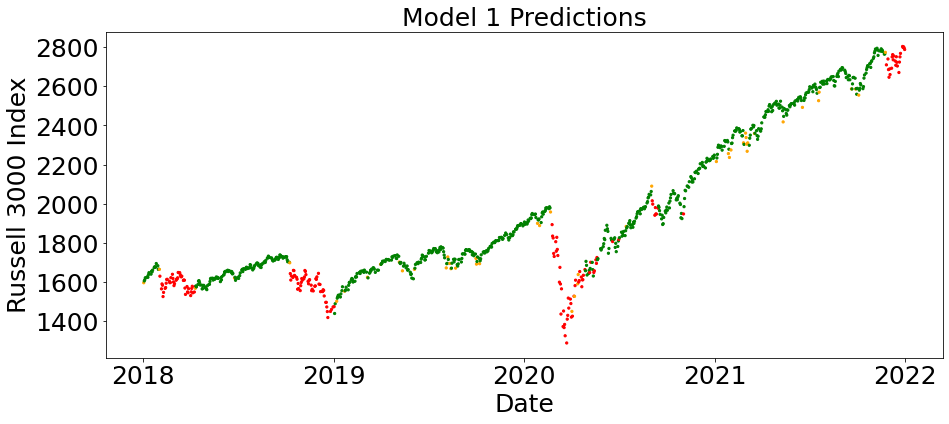

 Test Data:  1/3/18  to  12/31/21 
Buy and Hold:
Cumulative Return =  73.695 % | Annualized Return =  15.424 %
Sharpe Ratio of monthly returns =  0.251


Trading Strategy:
Cumulative Return =  173.545 % | Annualized Return =  29.879 %
Number of trades =  91
Sharpe Ratio of monthly returns =  0.592




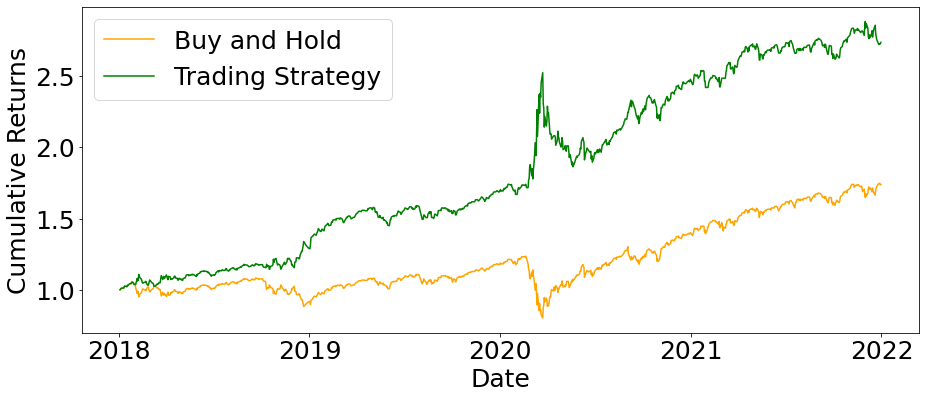

In [32]:
model_outperformance = []
excess_returns = []

m1_outperforms = 0
model1_excess = []
m1_hmm_train = data_train[['Adj Close', 'HMM', 'Model1']]
m1_hmm_test = data_test[['Adj Close', 'HMM', 'Model1']]

m1_hmm_train = get_final_state(m1_hmm_train, 'Model1')
m1_hmm_test = get_final_state(m1_hmm_test, 'Model1')

print("Test:")
plot_graph2(m1_hmm_test, string='Model 1 Predictions')

m1_hmm_final = m1_hmm_train.append(m1_hmm_test)

run(m1_hmm_final, total=False, train=False, test=True)

Test:


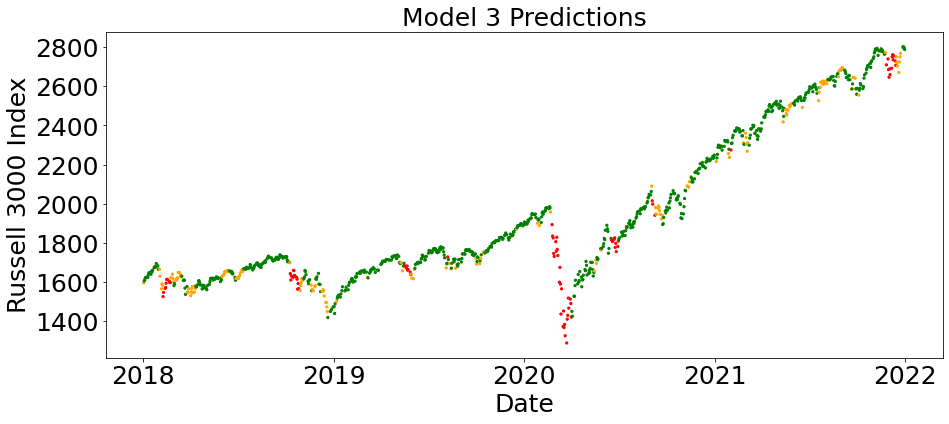

 Test Data:  1/3/18  to  12/31/21 
Buy and Hold:
Cumulative Return =  73.695 % | Annualized Return =  15.424 %
Sharpe Ratio of monthly returns =  0.251


Trading Strategy:
Cumulative Return =  211.627 % | Annualized Return =  34.352 %
Number of trades =  113
Sharpe Ratio of monthly returns =  0.511




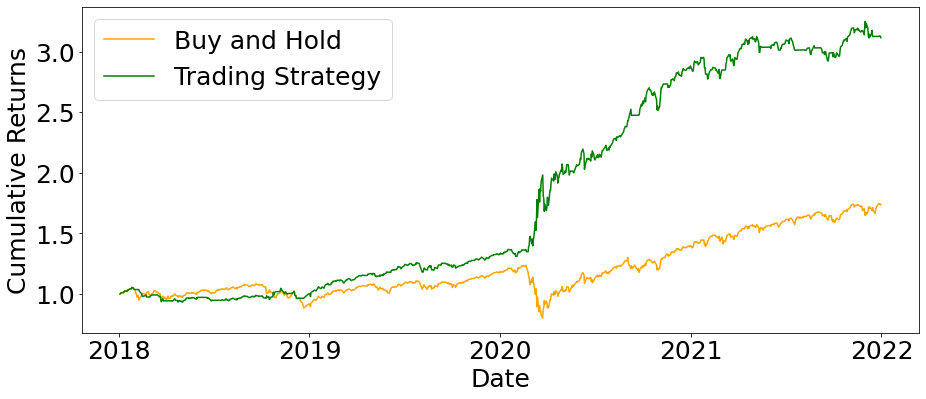

In [33]:
vvol_hmm_train = data_train[['Adj Close', 'HMM', 'VVol Thresh State']]
vvol_hmm_test = data_test[['Adj Close', 'HMM', 'VVol Thresh State']]

vvol_hmm_train = get_final_state(vvol_hmm_train, 'VVol Thresh State')
vvol_hmm_test = get_final_state(vvol_hmm_test, 'VVol Thresh State')
#print("Train:")
#plot_graph2(vvol_hmm_train)
print("Test:")
plot_graph2(vvol_hmm_test, string='Model 3 Predictions')

vvol_hmm_final = vvol_hmm_train.append(vvol_hmm_test)

run(vvol_hmm_final, total=False, train=False, test=True)

Test:


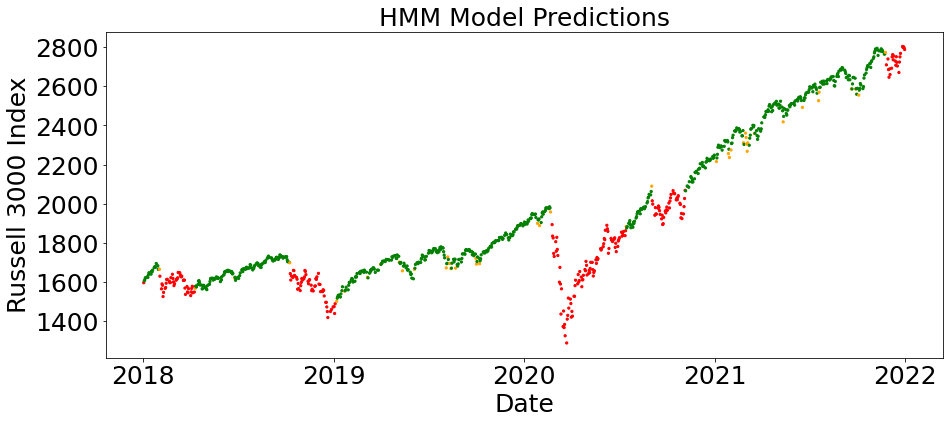

 Test Data:  1/3/18  to  12/31/21 
Buy and Hold:
Cumulative Return =  73.695 % | Annualized Return =  15.424 %
Sharpe Ratio of monthly returns =  0.251


Trading Strategy:
Cumulative Return =  106.985 % | Annualized Return =  20.803 %
Number of trades =  71
Sharpe Ratio of monthly returns =  0.407




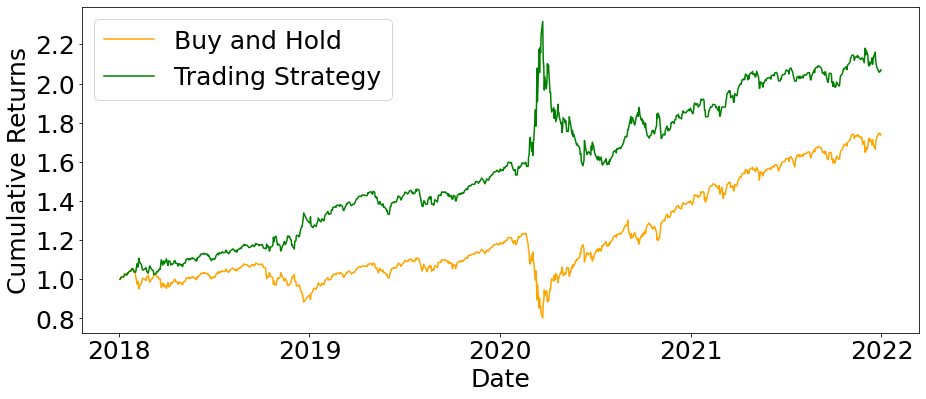

In [34]:
hmm_train = data_train[['Adj Close', 'HMM']]
hmm_train = hmm_train.rename(columns={'HMM':'State'})
hmm_test = data_test[['Adj Close', 'HMM']]
hmm_test = hmm_test.rename(columns={'HMM':'State'})


print("Test:")
plot_graph2(hmm_test, string='HMM Model Predictions')

hmm_final = hmm_train.append(hmm_test)

run(hmm_final, total=False, train=False, test=True)